Interactively figure out MGRS tiles and track numbers

In [117]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [119]:
yaml_file = 'events/chilcotin_river_landslide_and_flood_2024.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'chilcotin_river_landslide_and_flood_2024',
 'bounds': [-122.92087775, 51.83943495, -122.69035819, 51.88365439],
 'event_date': '2024-07-30',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [9, 133],
 'mgrs_tiles': ['10UEC'],
 'dist_hls_confirmed_change_min_days': 15,
 'source_id': 'Al Handwerger derived landslide and flood from Planet 3m; dry areas from HLS and ESA world cover by Charlie Marshak',
 'links': ['https://chilcotin-river-landslide-2024-bcgov03.hub.arcgis.com/',
  'https://www.bluemarble.nasa.gov/images/153195/chilcotin-rivers-landslide-lake-begins-draining']}

# Read Geojson

In [111]:
p_json = Path(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
p_parq = Path(f'external_validation_data_db/{event_dict["event_name"]}.parquet')
if p_json.exists():
    df_event = gpd.read_file(p_json)
else:
    df_event = gpd.read_parquet(p_parq)

In [112]:
# df_event.plot()

In [113]:
df_event.head()

,name,date,source_id,geometry
0,chilcotin_river_landslide_and_flood_2024,2024-07-30,Al Handwerger derived landslide and flood from...,"MULTIPOLYGON (((-122.74892 51.84087, -122.7488..."


In [114]:
df_event.total_bounds

array([-122.92087775,   51.83943495, -122.69035819,   51.88365439])

# Create Spatial AOI

In [115]:
aoi = box(*df_event.total_bounds)
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [107]:
bounds = aoi.bounds
bounds

(-122.92087775083773,
 51.839434949126336,
 -122.69035818640747,
 51.88365438924285)

# Find MGRS tiles and Explore

In [108]:
df_mgrs = gpd.read_parquet('mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
# remove antimeridian
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(-180, -60, -179, 60))]
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(179, -60, 180, 60))]

df_mgrs_overlapping.head()

,tile_id,epsg,utm_wkt,geometry
1,10UDC,32610,"MULTIPOLYGON(((399960 5800020,399960 5690220,5...","MULTIPOLYGON (((-124.46847 52.34135, -124.4366..."
2,10UEC,32610,"MULTIPOLYGON(((499980 5800020,499980 5690220,6...","MULTIPOLYGON (((-123.00029 52.35047, -123.0002..."


In [110]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [120]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['10UEC']

In [121]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

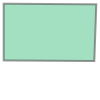

In [122]:
search_geo

# Explore Availability of RTC Data

In [123]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [124]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

178

In [125]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

58

In [126]:
# df_rtc_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
# df_rtc_post_e = df_rtc_post_e[df_rtc_post_e.pathNumber == 109].reset_index(drop=True)
# len(df_rtc_post_e)

In [127]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
df_aoi.explore(m=m)
m

In [131]:
df_rtc_resp_pre_e.pathNumber.unique()

array([ 13, 137])

In [129]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber.isin([71, 78])].boundary.reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

m

In [130]:
df_rtc_resp_post_e.head()

,geometry,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,...,validityStartDate,subswath,fileName,beamModeType,s3Urls,beamMode,additionalUrls,bistaticDelayCorrection,noiseCorrection,postProcessingFilter
0,"POLYGON ((-123.27336 52.16039, -122.63729 52.2...",52.303889,-122.673352,2024-08-23T02:04:03Z,OPERA_L2_RTC-S1_T137-292426-IW3_20240823T02040...,ASCENDING,137,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-23T02:04:00Z,...,None,IW3,OPERA_L2_RTC-S1_T137-292426-IW3_20240823T02040...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
1,"POLYGON ((-123.23028 51.99514, -122.59368 52.0...",52.138728,-122.631891,2024-08-23T02:04:00Z,OPERA_L2_RTC-S1_T137-292425-IW3_20240823T02035...,ASCENDING,137,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-23T02:03:57Z,...,None,IW3,OPERA_L2_RTC-S1_T137-292425-IW3_20240823T02035...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
2,"POLYGON ((-123.17985 51.83078, -122.55373 51.8...",51.973890,-122.588072,2024-08-23T02:03:58Z,OPERA_L2_RTC-S1_T137-292424-IW3_20240823T02035...,ASCENDING,137,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-23T02:03:54Z,...,None,IW3,OPERA_L2_RTC-S1_T137-292424-IW3_20240823T02035...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
3,"POLYGON ((-123.13103 51.66601, -122.50482 51.7...",51.819779,-122.545449,2024-08-23T02:03:55Z,OPERA_L2_RTC-S1_T137-292423-IW3_20240823T02035...,ASCENDING,137,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-23T02:03:52Z,...,None,IW3,OPERA_L2_RTC-S1_T137-292423-IW3_20240823T02035...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
4,"POLYGON ((-124.37519 51.47077, -123.65755 51.5...",51.640744,-123.704700,2024-08-23T02:03:54Z,OPERA_L2_RTC-S1_T137-292423-IW2_20240823T02035...,ASCENDING,137,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-23T02:03:51Z,...,None,IW2,OPERA_L2_RTC-S1_T137-292423-IW2_20240823T02035...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
